In [2]:
import MRzeroCore as mr0
import matplotlib.pyplot as plt
from numpy import pi

(flash)=
# Create a FLASH Sequence

This Notebook demonstrates a simple Fast Low Angle SHot sequence (FLASH). It is a simple gradient echo sequence with low TR and flip angles typically below 10°.

Always prefer to write a function that builds the sequence that takes all variables of interest (often flip angles, TE, TR and/or others) as arguments. This way one can easily build variations of the sequence or optimize the arguments with gradient descent when using pyTorch tensors for all variables.

In [3]:
def build_seq() -> mr0.Sequence:
    seq = mr0.Sequence()

    for i in range(64):
        rep = seq.new_rep(2 + 64 + 1)
        rep.pulse.usage = mr0.PulseUsage.EXCIT
        rep.pulse.angle = 7 * pi/180
        rep.pulse.phase = 0.5 * 137.50776405 * (i**2+i+2) * pi / 180

        rep.event_time[0] = 2e-3  # Pulse
        rep.event_time[1] = 2e-3  # Rewinder
        rep.event_time[2:-1] = 0.08e-3  # Readout
        rep.event_time[-1] = 2e-3  # Spoiler

        rep.gradm[1, 0] = -33
        rep.gradm[2:-1, 0] = 1
        rep.gradm[-1, 0] = 96 - 31

        # Linear reordered phase encoding
        rep.gradm[1, 1] = i - 32
        rep.gradm[-1, 1] = -rep.gradm[1, 1]

        rep.adc_usage[2:-1] = 1
        rep.adc_phase[2:-1] = pi - rep.pulse.phase

    return seq

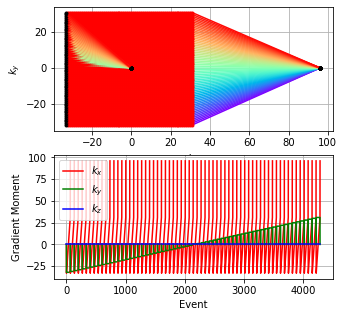

In [4]:
# Build the default FLASH and show the kspace
seq = build_seq()
seq.plot_kspace_trajectory()

VoxelGridPhantom
FOV: base * rel = tensor([0.1920, 0.1920, 0.1920]) * tensor([1., 1., 1.]) = tensor([0.1920, 0.1920, 0.1920])


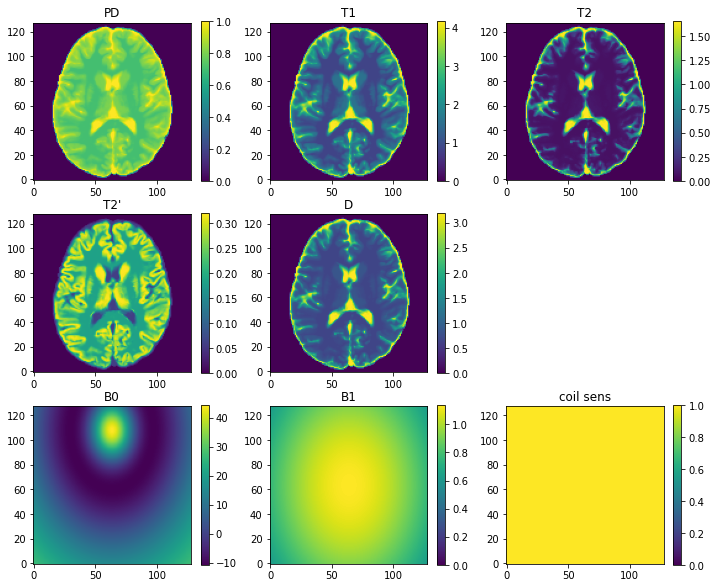

c:\Users\endresjn\Anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\endresjn\Anaconda3\lib\site-packages\MRzeroCore\phantom\voxel_grid_phantom.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2,


In [5]:
# Load a BrainWeb phantom for simulation

phantom = mr0.VoxelGridPhantom.brainweb("subject05.npz")
phantom = phantom.interpolate(128, 128, 32).slices([16])
phantom.plot()
data = phantom.build()

In [6]:
# Simulate the sequence

graph = mr0.compute_graph(seq, data)
signal = mr0.execute_graph(graph, seq, data)
reco = mr0.reco_adjoint(signal, seq.get_kspace())

Calculating repetition 64 / 64 - done
Detected FOV: (1.0, 1.0, 1.0)
Detected resolution: (64, 64, 1)


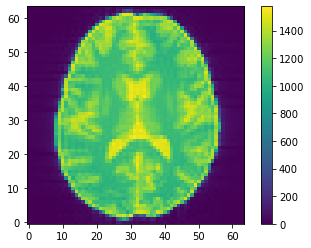

In [7]:
# Plot the result

plt.figure()
plt.imshow(reco.abs().cpu()[:, :, 0].T, origin='lower', vmin=0)
plt.colorbar()
plt.show()

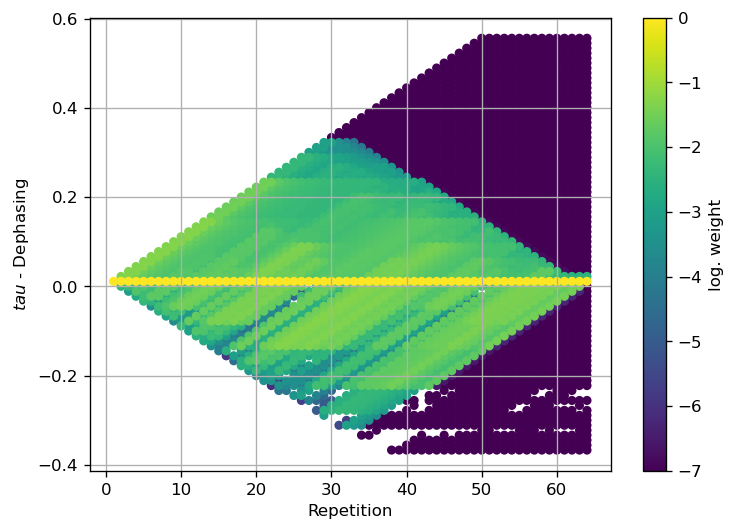

In [8]:
plt.figure(figsize=(7, 5), dpi=120)
graph.plot()
plt.grid()
plt.show()